In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout, Conv1D, MaxPooling1D, LSTM, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

In [ ]:
# Import dataset
# data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PhiUSIIL_Phishing_URL_Dataset.csv')

In [ ]:
data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

## Dataset description

1. The PhiUSIIL Phishing URL Dataset consists of 134,850 legitimate and 100,945 phishing URLs, with most URLs being recently active at the time of dataset creation.


2. Features are extracted from the source code and structure of each URL, capturing key attributes.


3. Unique features include 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', and 'TLDLegitimateProb', which are derived from more fundamental URL characteristics.


4. These derived features aim to quantify various aspects like character distribution, title-URL consistency, and top-level domain (TLD) legitimacy.


5. The dataset provides both legitimate and phishing labels, making it ideal for binary classification tasks.

In [ ]:
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
data.isnull().sum().sum()
# No empty cells

0

In [ ]:
data.duplicated().sum()
# No duplicated datas

0

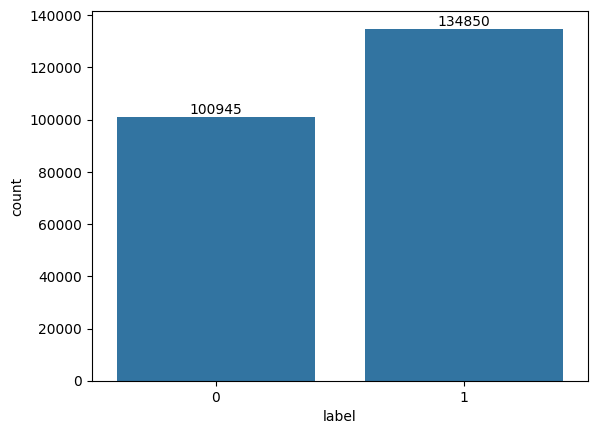

In [ ]:
ax = sns.countplot(x='label',data=data)
for i in ax.containers:
    ax.bar_label(i,)
# Class labels fairly balanced, SMOTE not required

In [ ]:
# Identify non-numerical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

print("Categorical Columns:")
print(categorical_columns)

print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['FILENAME', 'URL', 'Domain', 'TLD', 'Title']

Numerical Columns:
['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label']


## Feature Selection

1. The dataset was divided into two parts due to the large number of features, making it challenging to read and compare effectively.


2. Non-numerical categories have been removed.

### Correlation Matrix

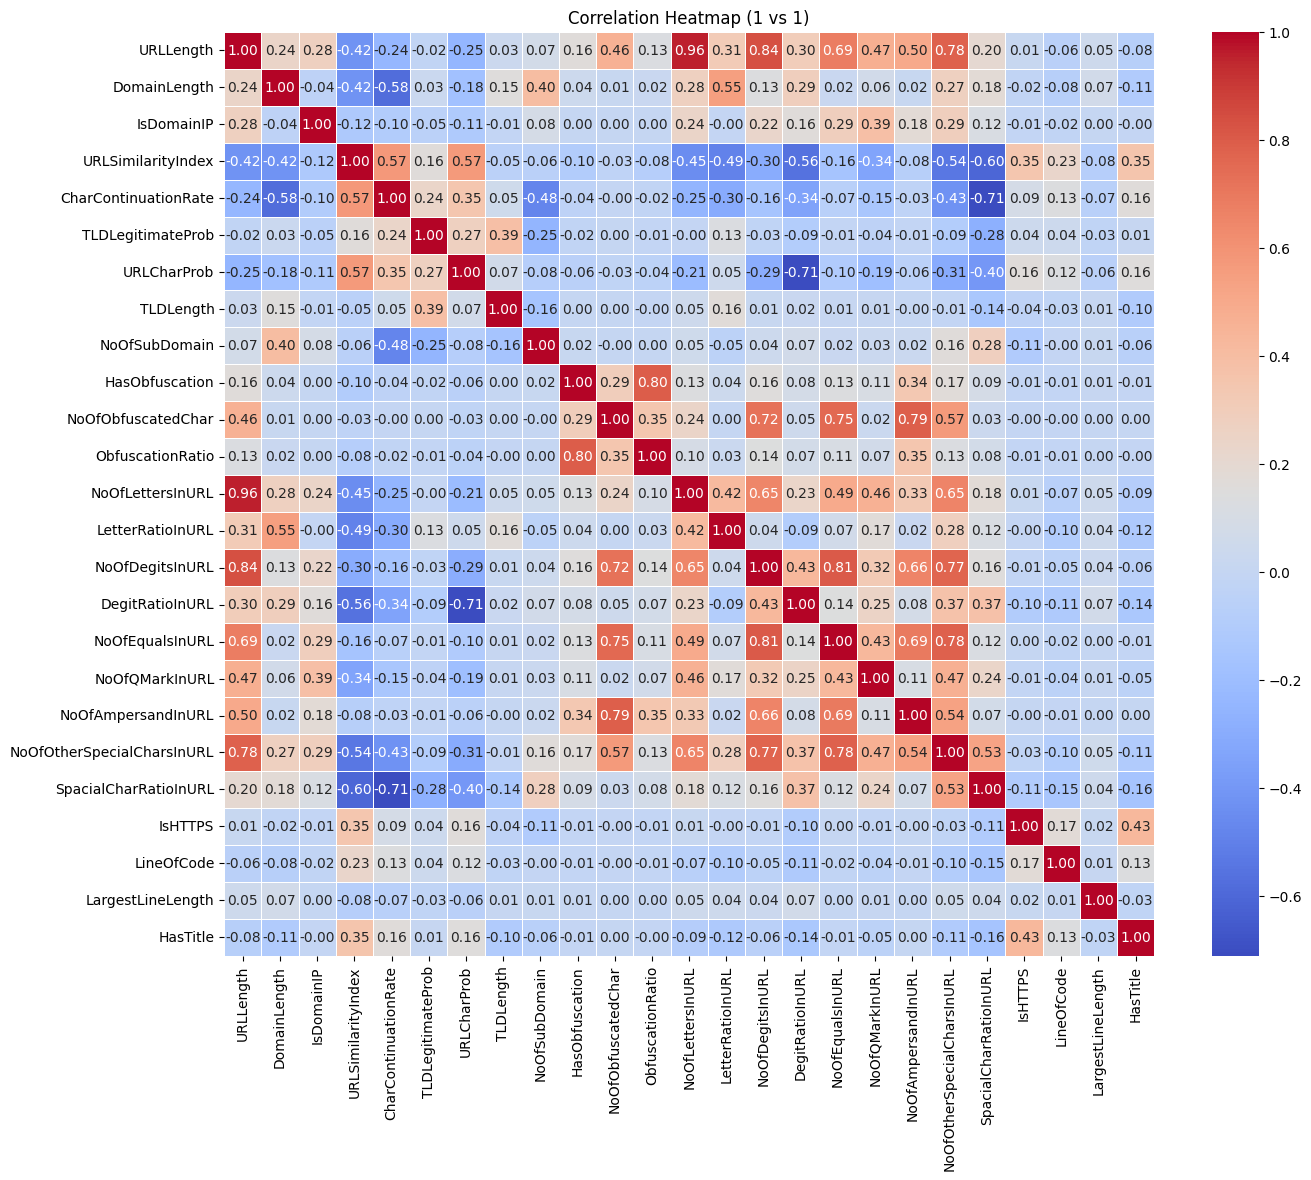

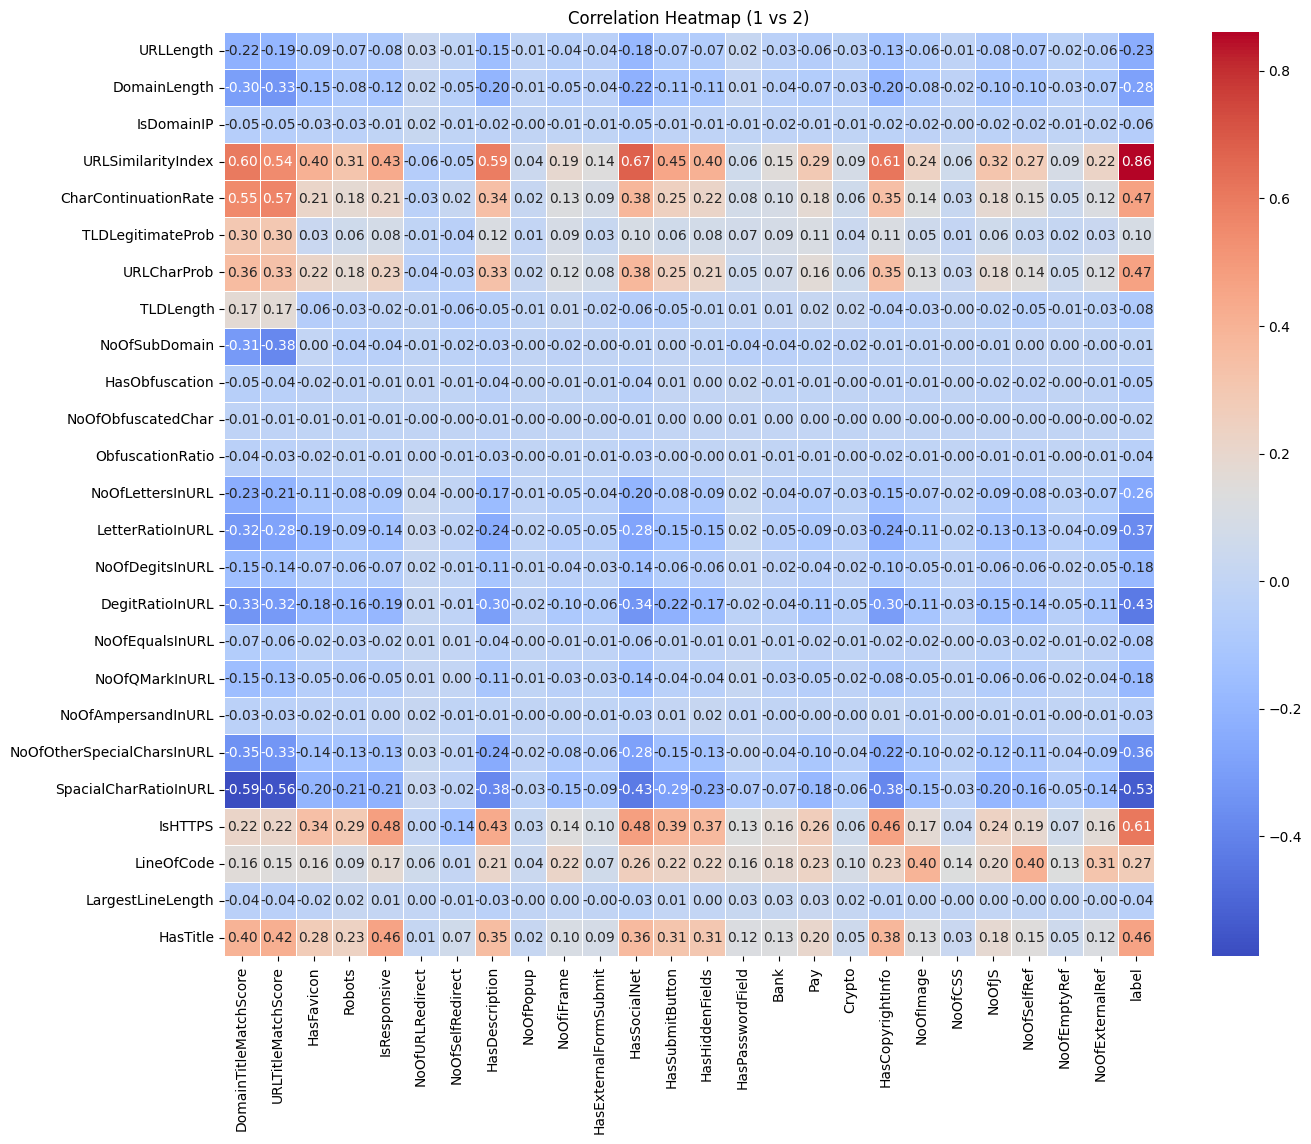

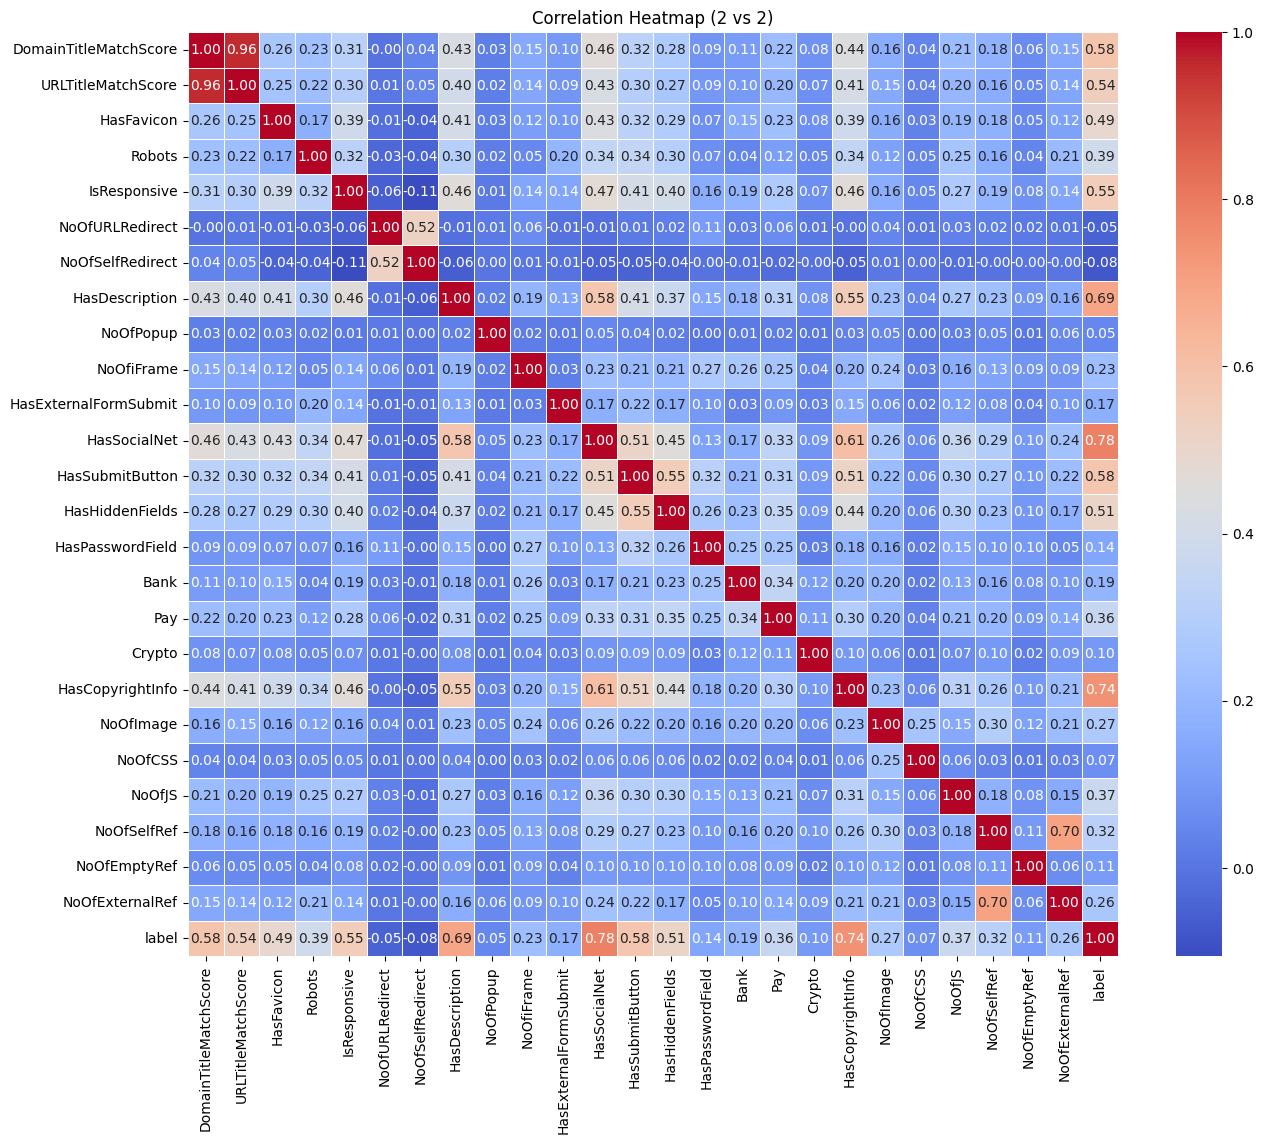

In [ ]:
numerical_data = data.select_dtypes(include=[np.number])

correlation_matrix = numerical_data.corr()

num_features = len(correlation_matrix)

mid_index = num_features // 2

# Split the correlation matrix into two halves
first_half = correlation_matrix.iloc[:mid_index, :mid_index]
second_half = correlation_matrix.iloc[mid_index:, mid_index:]
cross_half = correlation_matrix.iloc[:mid_index, mid_index:]

# Plot the first heatmap (1 vs 1)
plt.figure(figsize=(15, 12))
sns.heatmap(first_half, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (1 vs 1)')
plt.show()

# Plot the second heatmap (1 vs 2)
plt.figure(figsize=(15, 12))
sns.heatmap(cross_half, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (1 vs 2)')
plt.show()

# Plot the third heatmap (2 vs 2)
plt.figure(figsize=(15, 12))
sns.heatmap(second_half, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (2 vs 2)')
plt.show()

In [ ]:
high_corr = correlation_matrix[(correlation_matrix > 0.8) | (correlation_matrix < -0.8)]

# Exclude self-correlations
high_corr = high_corr.where(~np.eye(high_corr.shape[0], dtype=bool))
high_corr_pairs = high_corr.stack().dropna()

print(high_corr_pairs)

URLLength              NoOfLettersInURL         0.956047
                       NoOfDegitsInURL          0.835809
URLSimilarityIndex     label                    0.860358
NoOfLettersInURL       URLLength                0.956047
NoOfDegitsInURL        URLLength                0.835809
                       NoOfEqualsInURL          0.806024
NoOfEqualsInURL        NoOfDegitsInURL          0.806024
DomainTitleMatchScore  URLTitleMatchScore       0.961008
URLTitleMatchScore     DomainTitleMatchScore    0.961008
label                  URLSimilarityIndex       0.860358
dtype: float64


In [ ]:
variance = numerical_data.var()

print("Variance of each numeric feature:")
print(variance)

Variance of each numeric feature:
URLLength                     1.706859e+03
DomainLength                  8.373702e+01
IsDomainIP                    2.698431e-03
URLSimilarityIndex            8.396117e+02
CharContinuationRate          4.692961e-02
TLDLegitimateProb             6.331677e-02
URLCharProb                   1.120862e-04
TLDLength                     3.596865e-01
NoOfSubDomain                 3.611641e-01
HasObfuscation                2.052649e-03
NoOfObfuscatedChar            3.520311e+00
ObfuscationRatio              1.457109e-05
NoOfLettersInURL              8.462473e+02
LetterRatioInURL              1.520651e-02
NoOfDegitsInURL               1.412935e+02
DegitRatioInURL               5.026428e-03
NoOfEqualsInURL               8.736718e-01
NoOfQMarkInURL                3.744434e-02
NoOfAmpersandInURL            6.996445e-01
NoOfOtherSpecialCharsInURL    1.244399e+01
SpacialCharRatioInURL         1.049305e-03
IsHTTPS                       1.701240e-01
LineOfCode          

In [ ]:
features_to_drop = set()

for feature1, feature2 in high_corr_pairs.index:

    if feature1 == 'label' or feature2 == 'label':
        continue

    var1 = data[feature1].var()
    var2 = data[feature2].var()

    if var1 < var2:
        features_to_drop.add(feature1)
    else:
        features_to_drop.add(feature2)

# Drop the identified features from the dataset
data_reduced = numerical_data.drop(columns=features_to_drop)

print("Dropped features:")
print(features_to_drop)

print("\nRemaining features after removing features with lower variance from highly correlated pairs:")
print(data_reduced.columns)

print("\nNumber of remaining features:")
print(data_reduced.shape[1])

Dropped features:
{'URLTitleMatchScore', 'NoOfEqualsInURL', 'NoOfLettersInURL', 'NoOfDegitsInURL'}

Remaining features after removing features with lower variance from highly correlated pairs:
Index(['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
       'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar',
       'ObfuscationRatio', 'LetterRatioInURL', 'DegitRatioInURL',
       'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'DomainTitleMatchScore', 'HasFavicon', 'Robots',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription',
       'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJ

### Variance

In [ ]:
low_variance_filter = VarianceThreshold(threshold=0.01)
low_variance_features = data_reduced.columns[~low_variance_filter.fit(data_reduced).get_support()].tolist()

# Drop low variance features except for 'label'
low_variance_features = [feature for feature in low_variance_features if feature != 'label']
data_reduced = data_reduced.drop(columns=low_variance_features)

# Display results
print("Low variance features removed:")
print(low_variance_features)

remaining_features = data_reduced.columns.tolist()
print("\nRemaining features in the dataset:")
print(remaining_features)

print("\nNumber of remaining features:")
print(data_reduced.shape[1])

Low variance features removed:
['IsDomainIP', 'URLCharProb', 'HasObfuscation', 'ObfuscationRatio', 'DegitRatioInURL', 'SpacialCharRatioInURL']

Remaining features in the dataset:
['URLLength', 'DomainLength', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'LetterRatioInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label']

Number of remaining features:
41


## Model Building with 40 features

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Identify the features (X) and target (y)
# (1 for legitimate, 0 for phishing)
X = data_reduced.drop('label', axis=1)
y = data_reduced['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = ['Phishing', 'Non-Phishing']

### KNN

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled_kr = scaler.fit_transform(X_train)
X_test_scaled_kr = scaler.transform(X_test)

In [ ]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=100)

# Training the KNN model
knn.fit(X_train_scaled_kr, y_train)

y_train_pred_kr = knn.predict(X_train_scaled_kr)
y_test_pred_kr = knn.predict(X_test_scaled_kr)

In [ ]:
# Confusion matrices
knn_cm_train = confusion_matrix(y_train, y_train_pred_kr)
knn_cm_test = confusion_matrix(y_test, y_test_pred_kr)

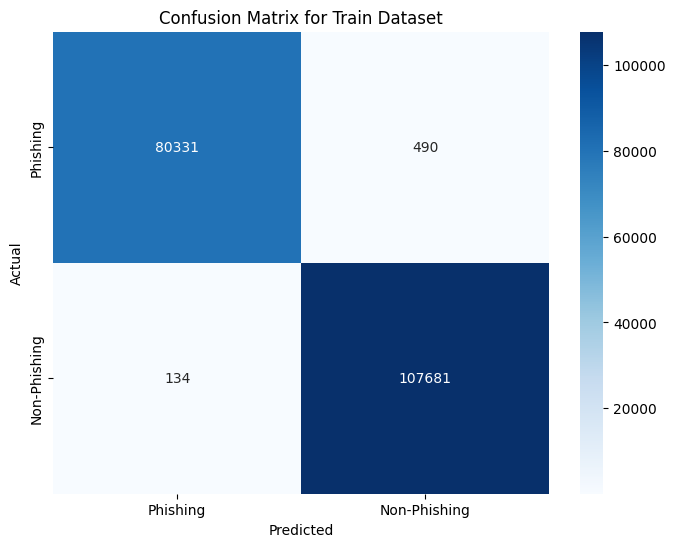

Train dataset accuracy: 99.88%


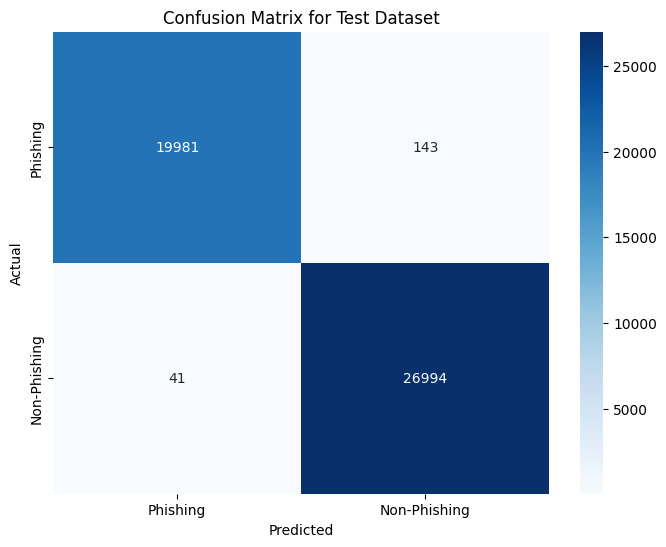

Test dataset accuracy: 99.85%


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Decision Tree

In [ ]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

best_dt.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Make predictions
y_pred_dt = best_dt.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



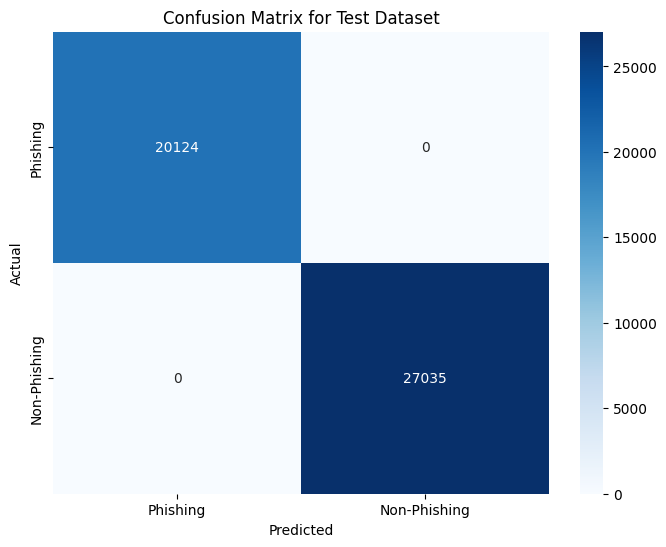

Test dataset accuracy: 100.00%
                       Feature  Importance
2           URLSimilarityIndex    0.986398
13                  LineOfCode    0.013147
12                     IsHTTPS    0.000411
6                NoOfSubDomain    0.000043
0                    URLLength    0.000000
24                  NoOfiFrame    0.000000
25       HasExternalFormSubmit    0.000000
26                HasSocialNet    0.000000
27             HasSubmitButton    0.000000
28             HasHiddenFields    0.000000
29            HasPasswordField    0.000000
30                        Bank    0.000000
31                         Pay    0.000000
22              HasDescription    0.000000
32                      Crypto    0.000000
33            HasCopyrightInfo    0.000000
34                   NoOfImage    0.000000
35                     NoOfCSS    0.000000
36                      NoOfJS    0.000000
37                 NoOfSelfRef    0.000000
38                NoOfEmptyRef    0.000000
23                   No

In [ ]:
dt_cm_test = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

feature_importances_dt = best_dt.feature_importances_

# Display feature importance
importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances_dt
})

# Sort the DataFrame by importance score in descending order
importance_dt = importance_dt.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(importance_dt)

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for Random Search
param_distributions = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 21, 2)),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Get the best hyperparameters and refit the model with the best estimator
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Make predictions on the test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



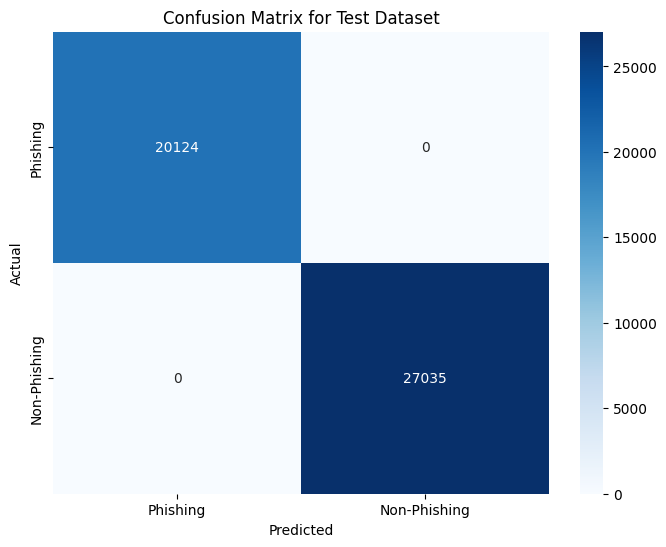

In [ ]:
rf_cm_test = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

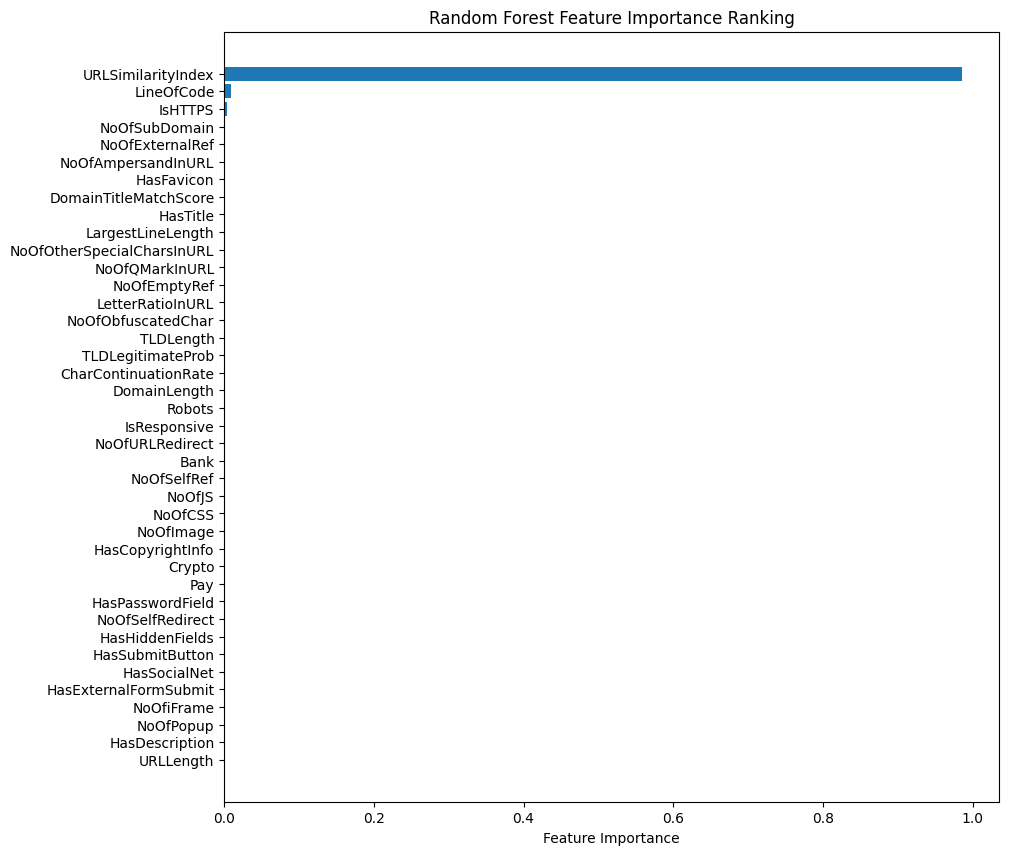

Random Forest Feature Importance (sorted):
URLSimilarityIndex: 0.9863
LineOfCode: 0.0097
IsHTTPS: 0.0039
NoOfSubDomain: 0.0000
NoOfExternalRef: 0.0000
NoOfAmpersandInURL: 0.0000
HasFavicon: 0.0000
DomainTitleMatchScore: 0.0000
HasTitle: 0.0000
LargestLineLength: 0.0000
NoOfOtherSpecialCharsInURL: 0.0000
NoOfQMarkInURL: 0.0000
NoOfEmptyRef: 0.0000
LetterRatioInURL: 0.0000
NoOfObfuscatedChar: 0.0000
TLDLength: 0.0000
TLDLegitimateProb: 0.0000
CharContinuationRate: 0.0000
DomainLength: 0.0000
Robots: 0.0000
IsResponsive: 0.0000
NoOfURLRedirect: 0.0000
Bank: 0.0000
NoOfSelfRef: 0.0000
NoOfJS: 0.0000
NoOfCSS: 0.0000
NoOfImage: 0.0000
HasCopyrightInfo: 0.0000
Crypto: 0.0000
Pay: 0.0000
HasPasswordField: 0.0000
NoOfSelfRedirect: 0.0000
HasHiddenFields: 0.0000
HasSubmitButton: 0.0000
HasSocialNet: 0.0000
HasExternalFormSubmit: 0.0000
NoOfiFrame: 0.0000
NoOfPopup: 0.0000
HasDescription: 0.0000
URLLength: 0.0000


In [ ]:
# Feature Importance for Random Forest
feature_importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 10))
plt.title("Random Forest Feature Importance Ranking")
plt.barh(range(len(indices_rf)), feature_importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [X_train.columns[i] for i in indices_rf])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.show()

# Print sorted feature importance values for Random Forest
print("Random Forest Feature Importance (sorted):")
for idx in indices_rf:
    print(f"{X_train.columns[idx]}: {feature_importances_rf[idx]:.4f}")

We have experimented with the removal of dominant features, such as `URLSimilarityIndex` and `NoOfExternalRef`, to retrain the model and evaluate model performance without them. This will force the model to use other features and should reduce the overfitting. Additionally, we also hypertuned and pruned the decision tree.

However, the model's performance showed little variation and remained consistently strong.

### Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



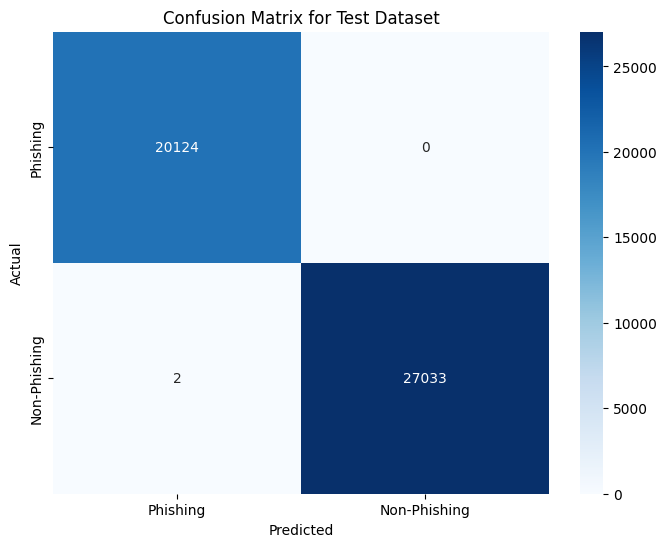

Test dataset accuracy: 99.99%

Top 10 Most Important Features:
                       feature  importance
12                     IsHTTPS    7.575737
0                    URLLength    3.314403
1                 DomainLength    3.218381
22              HasDescription    1.742054
3         CharContinuationRate    1.741668
33            HasCopyrightInfo    1.599919
26                HasSocialNet    1.546715
17                  HasFavicon    1.130380
11  NoOfOtherSpecialCharsInURL    0.986140
27             HasSubmitButton    0.885857


In [ ]:
#Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

lr_cm_test = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(model.coef_[0])
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

#### Addition of Autoencoder

In [ ]:
features = data_reduced.iloc[:, :-1]  # All columns except the last one(X)
label = data_reduced.iloc[:, -1] # (y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_train_lra, X_test_lra, y_train_lra, y_test_lra = train_test_split(X_scaled, label, test_size=0.2, random_state=42)

input_dim = X_train_lra.shape[1]  # Number of input features

In [ ]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)  # first encoding layer
encoded = Dense(16, activation='relu')(encoded)      # second encoding layer
encoded = Dense(8, activation='relu')(encoded)       # bottleneck layer

# Decoder
decoded = Dense(16, activation='relu')(encoded)      # first decoding layer
decoded = Dense(32, activation='relu')(decoded)      # second decoding layer
decoded = Dense(input_dim, activation='linear')(decoded)  # output layer

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train_lra, X_train_lra,
                         epochs=50,
                         batch_size=32,
                         shuffle=True,
                         validation_split=0.2,
                         verbose=1)

encoder = Model(input_layer, encoded)
encoded_features_train = encoder.predict(X_train_lra)
encoded_features_test = encoder.predict(X_test_lra)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(encoded_features_train, y_train_lra)

y_pred_lra = classifier.predict(encoded_features_test)

Epoch 1/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 4s 695us/step - loss: 0.6974 - val_loss: 0.4120
Epoch 2/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 677us/step - loss: 0.4182 - val_loss: 0.3396
Epoch 3/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 677us/step - loss: 0.3620 - val_loss: 0.4460
Epoch 4/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - loss: 0.4751 - val_loss: 0.3136
Epoch 5/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 672us/step - loss: 0.3688 - val_loss: 0.2699
Epoch 6/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 654us/step - loss: 0.3078 - val_loss: 0.2832
Epoch 7/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 637us/step - loss: 0.3293 - val_loss: 0.2690
Epoch 8/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 631us/step - loss: 0.2876 - val_loss: 0.2544
Epoch 9/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 629us/step - loss: 0.2900 - val_loss: 0.2861
Epoch 10/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - loss: 0.2801 - val_loss: 0.2928
Epoch 11/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - loss: 0.2928 - val_loss: 0.2383
Epoch 12

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



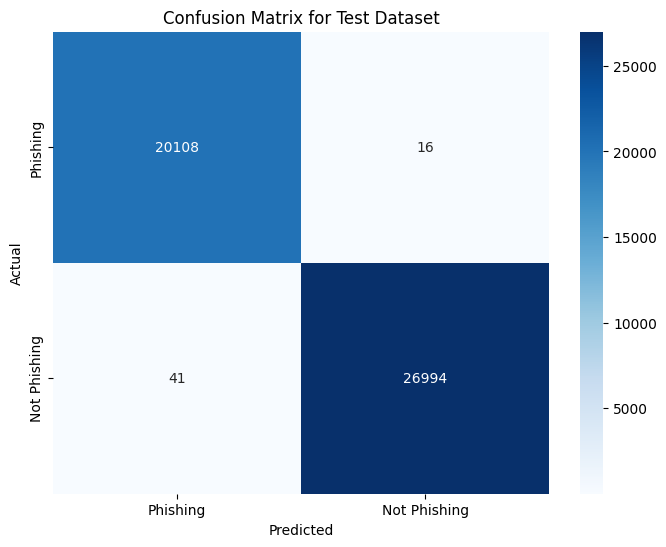

Test dataset accuracy: 99.85%


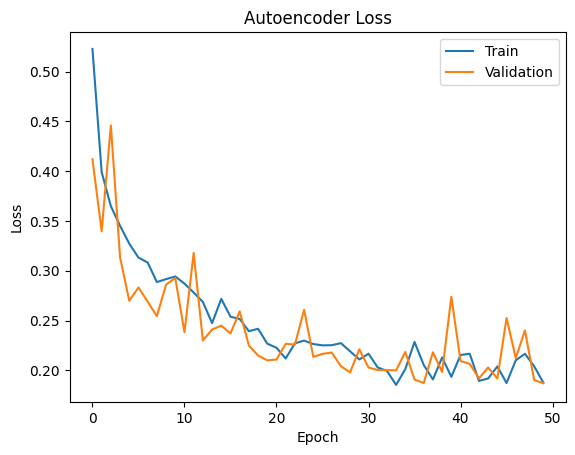

In [ ]:
print("Classification Report:")
print(classification_report(y_test_lra, y_pred_lra))

lra_cm_test = confusion_matrix(y_test_lra, y_pred_lra)

plt.figure(figsize=(8, 6))
sns.heatmap(lra_cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Building with URL-related features





### Feature Selection

In [ ]:
data_reduced.columns

Index(['URLLength', 'DomainLength', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'TLDLength',
       'NoOfSubDomain', 'NoOfObfuscatedChar', 'LetterRatioInURL',
       'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle',
       'DomainTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive',
       'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
       'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label'],
      dtype='object')

In [ ]:
columns_to_keep_url = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain',
                       'NoOfQMarkInURL', 'NoOfAmpersandInURL','NoOfObfuscatedChar',
                       'NoOfOtherSpecialCharsInURL', 'IsHTTPS', 'label']

data_reduced_url = data_reduced[columns_to_keep_url]


# Display the first few rows of the reduced dataset
data_reduced_url.head()

,URLLength,DomainLength,TLDLength,NoOfSubDomain,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfObfuscatedChar,NoOfOtherSpecialCharsInURL,IsHTTPS,label
0,31,24,3,1,0,0,0,1,1,1
1,23,16,2,1,0,0,0,2,1,1
2,29,22,2,2,0,0,0,2,1,1
3,26,19,3,1,0,0,0,1,1,1
4,33,26,3,1,0,0,0,1,1,1


In [ ]:
print("\nNumber of remaining features:")
print(data_reduced_url.shape[1])


Number of remaining features:
10


In [ ]:
# Identify the features (X) and target (y)
# (1 for legitimate, 0 for phishing)
X_url = data_reduced_url.drop('label', axis=1)
y_url = data_reduced_url['label']

# Train-test split
X_train_url, X_test_url, y_train_url, y_test_url = train_test_split(X_url, y_url, test_size=0.2, random_state=42)

classes = ['Phishing', 'Not Phishing']

### KNN

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_url_kr = scaler.fit_transform(X_train_url)
X_test_url_kr = scaler.transform(X_test_url)

In [ ]:
# Initialize the KNN classifier
knn_url = KNeighborsClassifier(n_neighbors=100)

# Training the KNN model
knn_url.fit(X_train_url_kr, y_train_url)

y_test_pred_url_kr = knn_url.predict(X_test_url_kr)

In [ ]:
# Confusion matrices
knn_cm_test_url = confusion_matrix(y_test_url, y_test_pred_url_kr)

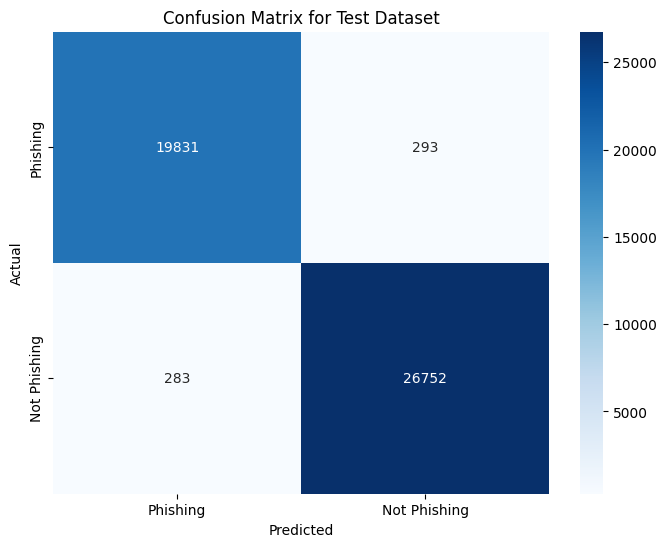

Test dataset accuracy: 98.95%


In [ ]:
# Plotting confusion matrix for test dataset
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm_test_url, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Decision Tree

In [ ]:
# Initialize the Decision Tree Classifier
dt_url = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search with cross-validation (5-fold)
grid_search = GridSearchCV(estimator=dt_url, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_url, y_train_url)

# Get the best hyperparameters and refit the model with the best estimator
best_dt_url = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Train the model using the best hyperparameters on the resampled training data
best_dt_url.fit(X_train_url, y_train_url)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
# Make predictions
y_pred_dt_url = best_dt_url.predict(X_test_url)

# Evaluate the accuracy
accuracy = accuracy_score(y_test_url, y_pred_dt_url)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_url, y_pred_dt_url))

Accuracy: 99.69%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



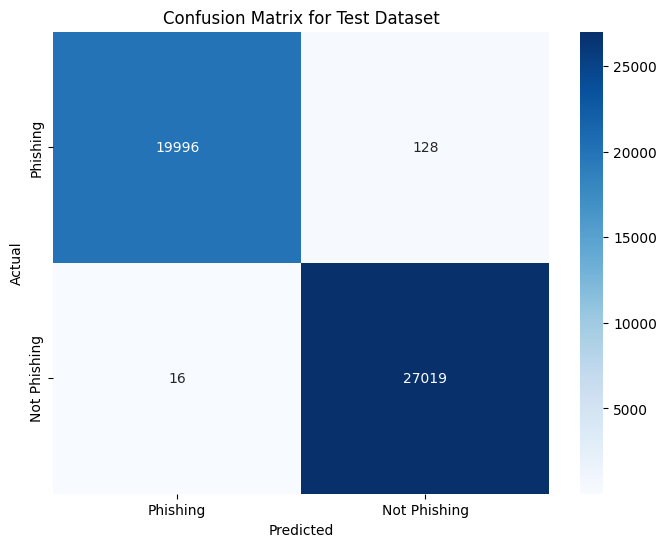

Test dataset accuracy: 99.94%


In [ ]:
dt_cm_test_url = confusion_matrix(y_test_url, y_pred_dt_url)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm_test_url, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Random Forest

In [ ]:
rf_url = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for Random Search
param_distributions = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 21, 2)),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Perform Randomized Search with cross-validation
random_search_url = RandomizedSearchCV(
    estimator=rf_url,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model on the training data
random_search_url.fit(X_train_url, y_train_url)

# Get the best hyperparameters and refit the model with the best estimator
best_rf_url = random_search_url.best_estimator_
print(f"Best Hyperparameters: {random_search_url.best_params_}")

# Make predictions on the test set
y_pred_rf_url = best_rf_url.predict(X_test_url)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_url, y_pred_rf_url))
print(classification_report(y_test_url, y_pred_rf_url))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Accuracy: 0.9970313195784474
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



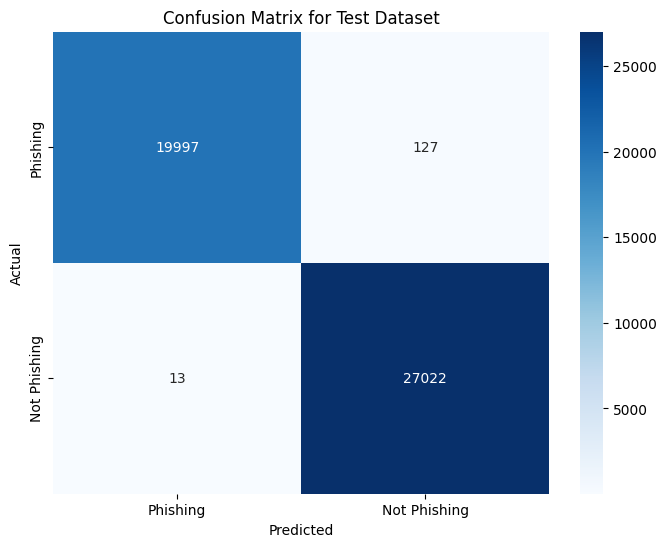

Test dataset accuracy: 99.95%


In [ ]:
rf_cm_test_url = confusion_matrix(y_test_url, y_pred_rf_url)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_test_url, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Logistic Regression

In [ ]:
model_url = LogisticRegression(max_iter=10000)
model_url.fit(X_train_url, y_train_url)
y_pred_lr_url = model_url.predict(X_test_url)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       0.99      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



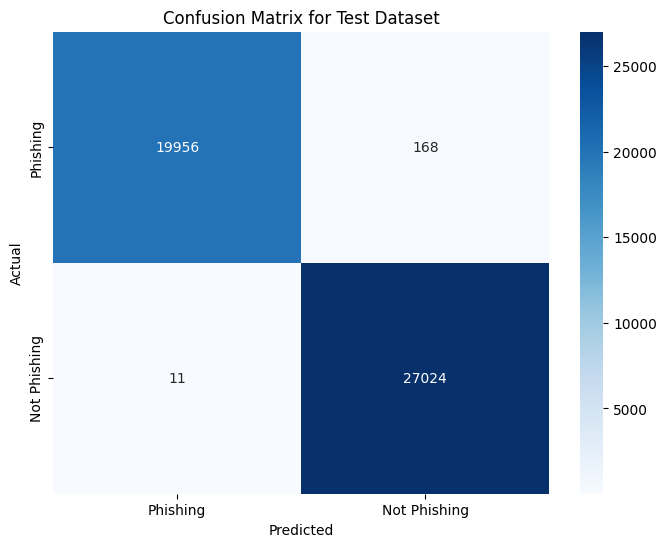

Test dataset accuracy: 99.96%

Top 10 Most Important Features:
                      feature  importance
8                     IsHTTPS   21.022430
0                   URLLength    8.542158
1                DomainLength    8.474887
7  NoOfOtherSpecialCharsInURL    1.564483
3               NoOfSubDomain    0.742381
2                   TLDLength    0.365565
5          NoOfAmpersandInURL    0.052983
6          NoOfObfuscatedChar    0.031370
4              NoOfQMarkInURL    0.028962


In [ ]:
#Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test_url, y_pred_lr_url))

lr_cm_test_url = confusion_matrix(y_test_url, y_pred_lr_url)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm_test_url, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

feature_importance_url = pd.DataFrame({
    'feature': X_url.columns,
    'importance': abs(model_url.coef_[0])
})
print("\nTop 10 Most Important Features:")
print(feature_importance_url.sort_values('importance', ascending=False).head(10))

#### Addition of Autoencoder

In [ ]:
features_url = data_reduced_url.iloc[:, :-1]  # All columns except the last one(X)
label_url = data_reduced_url.iloc[:, -1] # (y)

scaler_url = StandardScaler()
X_scaled_url = scaler_url.fit_transform(features_url)

X_train_lra_url, X_test_lra_url, y_train_lra_url, y_test_lra_url = train_test_split(X_scaled_url, label_url, test_size=0.2, random_state=42)

input_dim_url = X_train_lra_url.shape[1]  # Number of input features

In [ ]:
# Encoder
input_layer_url = Input(shape=(input_dim_url,))
encoded = Dense(32, activation='relu')(input_layer_url)  # first encoding layer
encoded = Dense(16, activation='relu')(encoded)      # second encoding layer
encoded = Dense(8, activation='relu')(encoded)       # bottleneck layer

# Decoder
decoded = Dense(16, activation='relu')(encoded)      # first decoding layer
decoded = Dense(32, activation='relu')(decoded)      # second decoding layer
decoded = Dense(input_dim_url, activation='linear')(decoded)  # output layer

autoencoder_url = Model(input_layer_url, decoded)
autoencoder_url.compile(optimizer='adam', loss='mse')

history_url = autoencoder_url.fit(X_train_lra_url, X_train_lra_url,
                         epochs=50,
                         batch_size=32,
                         shuffle=True,
                         validation_split=0.2,
                         verbose=1)

encoder_url = Model(input_layer_url, encoded)
encoded_features_train_url = encoder_url.predict(X_train_lra_url)
encoded_features_test_url = encoder_url.predict(X_test_lra_url)

classifier_url = LogisticRegression(max_iter=1000)
classifier_url.fit(encoded_features_train_url, y_train_lra_url)

y_pred_lra_url = classifier_url.predict(encoded_features_test_url)

Epoch 1/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 4s 643us/step - loss: 0.2087 - val_loss: 0.1559
Epoch 2/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 628us/step - loss: 0.0612 - val_loss: 0.1673
Epoch 3/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 629us/step - loss: 0.0297 - val_loss: 0.1303
Epoch 4/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 621us/step - loss: 0.0297 - val_loss: 0.0331
Epoch 5/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 622us/step - loss: 0.0082 - val_loss: 0.0585
Epoch 6/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 620us/step - loss: 0.0225 - val_loss: 0.0422
Epoch 7/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 621us/step - loss: 0.0254 - val_loss: 0.0213
Epoch 8/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 619us/step - loss: 0.0082 - val_loss: 0.1356
Epoch 9/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 623us/step - loss: 0.0568 - val_loss: 0.0560
Epoch 10/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 623us/step - loss: 0.0086 - val_loss: 0.0735
Epoch 11/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 3s 619us/step - loss: 0.0110 - val_loss: 0.0579
Epoch 12

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     20124
           1       0.97      0.99      0.98     27035

    accuracy                           0.98     47159
   macro avg       0.98      0.98      0.98     47159
weighted avg       0.98      0.98      0.98     47159



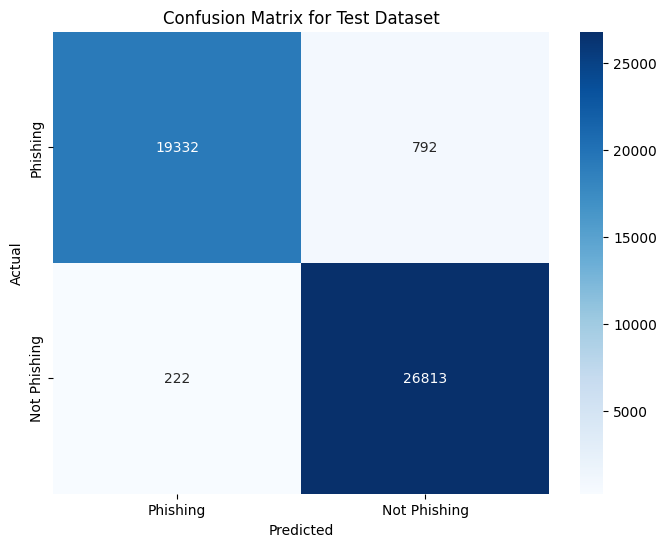

Test dataset accuracy: 99.18%


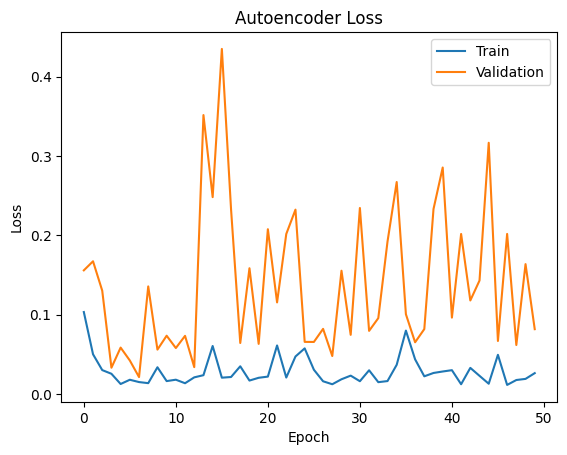

In [ ]:
print("Classification Report:")
print(classification_report(y_test_lra_url, y_pred_lra_url))

lra_cm_test_url = confusion_matrix(y_test_lra_url, y_pred_lra_url)

plt.figure(figsize=(8, 6))
sns.heatmap(lra_cm_test_url, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

plt.plot(history_url.history['loss'])
plt.plot(history_url.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Building with website-related features

### Feature Selection

In [ ]:
columns_to_keep_web = ['HasTitle', 'HasFavicon', 'IsResponsive', 'NoOfURLRedirect',
                              'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
                              'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
                              'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
                              'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfSelfRef',
                              'NoOfEmptyRef', 'NoOfExternalRef', 'label']

data_reduced_web = data_reduced[columns_to_keep_web]

data_reduced_web.head()

,HasTitle,HasFavicon,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,...,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,34,119,0,124,1
1,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,1,50,39,0,217,1
2,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,1,10,42,2,5,1
3,1,0,1,0,0,0,1,0,1,1,...,0,0,1,1,1,3,22,1,31,1
4,1,0,1,1,1,1,0,0,1,1,...,0,1,1,0,1,244,72,1,85,1


In [ ]:
print("\nNumber of remaining features:")
print(data_reduced_web.shape[1])


Number of remaining features:
21


In [ ]:
# Identify the features (X) and target (y)
# (1 for legitimate, 0 for phishing)
X_web = data_reduced_web.drop('label', axis=1)
y_web = data_reduced_web['label']

# Train-test split
X_train_web, X_test_web, y_train_web, y_test_web = train_test_split(X_web, y_web, test_size=0.2, random_state=42)

### KNN

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_web_kr = scaler.fit_transform(X_train_web)
X_test_web_kr = scaler.transform(X_test_web)

In [ ]:
# Initialize the KNN classifier
knn_web = KNeighborsClassifier(n_neighbors=100)

# Training the KNN model
knn_web.fit(X_train_web_kr, y_train_web)

y_test_pred_web_kr = knn_web.predict(X_test_web_kr)

In [ ]:
# Confusion matrices
knn_cm_test_web = confusion_matrix(y_test_web, y_test_pred_web_kr)

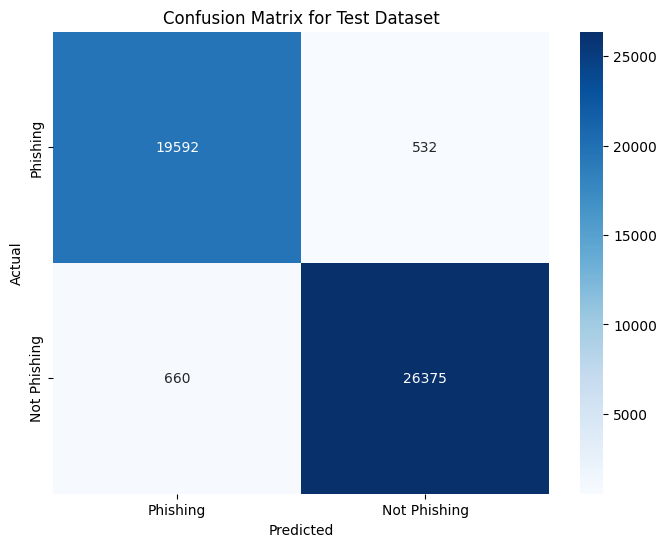

Test dataset accuracy: 97.56%


In [ ]:
# Plotting confusion matrix for test dataset
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm_test_web, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Decision Tree

In [ ]:
# Initialize the Decision Tree Classifier
dt_web = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search with cross-validation (5-fold)
grid_search = GridSearchCV(estimator=dt_web, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_web_kr, y_train_web)

# Get the best hyperparameters and refit the model with the best estimator
best_dt_web = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Train the model using the best hyperparameters on the resampled training data
best_dt_web.fit(X_train_web_kr, y_train_web)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, random_state=42)

In [ ]:
# Make predictions
y_pred_dt_web = best_dt_web.predict(X_test_web_kr)

# Evaluate the accuracy
accuracy = accuracy_score(y_test_web, y_pred_dt_web)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_web, y_pred_dt_web))

Accuracy: 99.20%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20124
           1       0.99      0.99      0.99     27035

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159



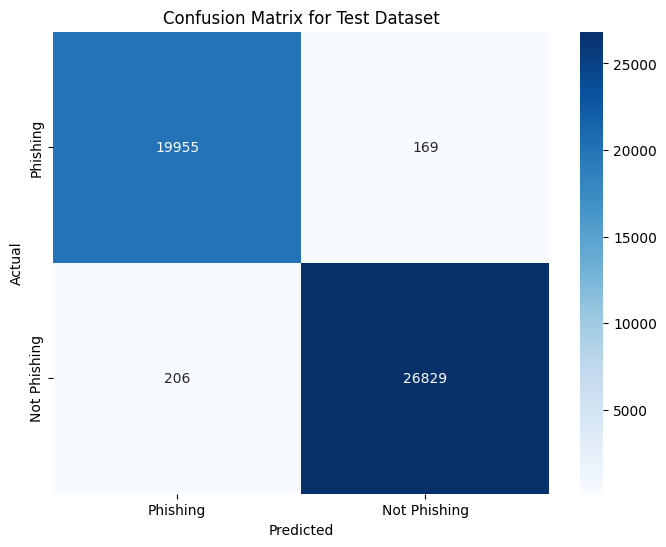

Test dataset accuracy: 99.24%


In [ ]:
dt_cm_test_web = confusion_matrix(y_test_web, y_pred_dt_web)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm_test_web, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Random Forest

In [ ]:
rf_web = RandomForestClassifier(random_state=42)

# hyperparameter grid for Random Search
param_distributions = {
    'n_estimators': np.arange(50, 301, 50),  # Number of trees in the forest
    'max_depth': [None] + list(np.arange(5, 21, 2)),  # Max depth of the trees
    'min_samples_split': [2, 5, 10, 20],  # Min samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],  # Min samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Randomized Search with cross-validation
random_search_web = RandomizedSearchCV(
    estimator=rf_web,
    param_distributions=param_distributions,
    n_iter=100,  # Number of different combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the model on the training data
random_search_web.fit(X_train_web, y_train_web)

# Get the best hyperparameters and refit the model with the best estimator
best_rf_web = random_search_web.best_estimator_
print(f"Best Hyperparameters: {random_search_web.best_params_}")

# Make predictions on the test set
y_pred_rf_web = best_rf_web.predict(X_test_web)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_web, y_pred_rf_web))
print(classification_report(y_test_web, y_pred_rf_web))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 19}
Accuracy: 0.9953561356262856
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20124
           1       0.99      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



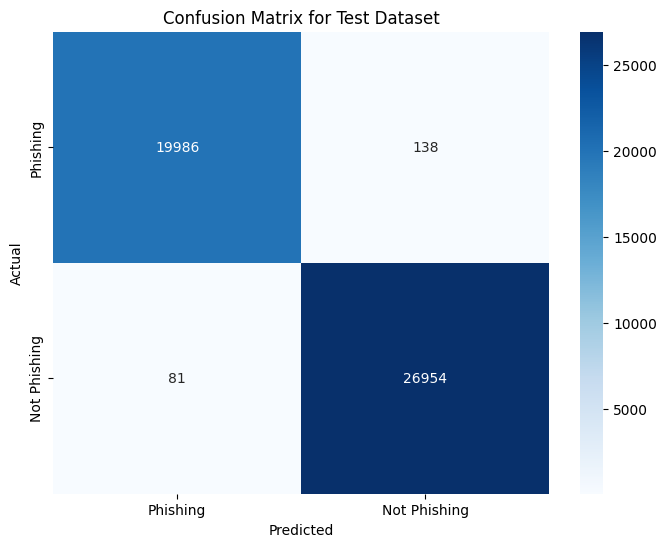

Test dataset accuracy: 99.70%


In [ ]:
rf_cm_test_web = confusion_matrix(y_test_web, y_pred_rf_web)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_test_web, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

### Logistic Regression

In [ ]:
model_web = LogisticRegression(max_iter=10000)
model_web.fit(X_train_web, y_train_web)
y_pred_lr_web = model_web.predict(X_test_web)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20124
           1       0.99      0.99      0.99     27035

    accuracy                           0.99     47159
   macro avg       0.98      0.99      0.98     47159
weighted avg       0.99      0.99      0.99     47159



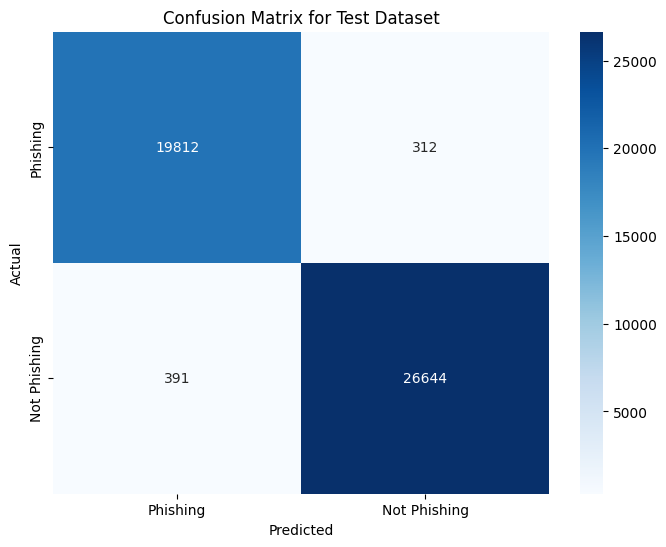

Test dataset accuracy: 99.96%

Top 10 Most Important Features:
                  feature  importance
8            HasSocialNet    3.310761
0                HasTitle    2.809706
5          HasDescription    2.416452
12                   Bank    2.234559
15       HasCopyrightInfo    2.232126
11       HasPasswordField    1.388086
3         NoOfURLRedirect    0.840604
7   HasExternalFormSubmit    0.600087
6               NoOfPopup    0.472952
2            IsResponsive    0.315820


In [ ]:
#Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test_web, y_pred_lr_web))

lr_cm_test_web = confusion_matrix(y_test_web, y_pred_lr_web)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm_test_web, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()


feature_importance_web = pd.DataFrame({
    'feature': X_web.columns,
    'importance': abs(model_web.coef_[0])
})
print("\nTop 10 Most Important Features:")
print(feature_importance_web.sort_values('importance', ascending=False).head(10))

#### Addition of Autoencoder

In [ ]:
features_web = data_reduced_web.iloc[:, :-1]  # All columns except the last one(X)
label_web = data_reduced_web.iloc[:, -1] # (y)

scaler_web = StandardScaler()
X_scaled_web = scaler_web.fit_transform(features_url)

X_train_lra_web, X_test_lra_web, y_train_lra_web, y_test_lra_web = train_test_split(X_scaled_web, label_web, test_size=0.2, random_state=42)

input_dim_web = X_train_lra_web.shape[1]  # Number of input features

In [ ]:
# Encoder
input_layer_web = Input(shape=(input_dim_web,))
encoded = Dense(32, activation='relu')(input_layer_web)  # first encoding layer
encoded = Dense(16, activation='relu')(encoded)      # second encoding layer
encoded = Dense(8, activation='relu')(encoded)       # bottleneck layer

# Decoder
decoded = Dense(16, activation='relu')(encoded)      # first decoding layer
decoded = Dense(32, activation='relu')(decoded)      # second decoding layer
decoded = Dense(input_dim_web, activation='linear')(decoded)  # output layer

autoencoder_web = Model(input_layer_web, decoded)
autoencoder_web.compile(optimizer='adam', loss='mse')

history_web = autoencoder_web.fit(X_train_lra_web, X_train_lra_web,
                         epochs=50,
                         batch_size=32,
                         shuffle=True,
                         validation_split=0.2,
                         verbose=1)

encoder_web = Model(input_layer_web, encoded)
encoded_features_train_web = encoder_web.predict(X_train_lra_web)
encoded_features_test_web = encoder_web.predict(X_test_lra_web)

classifier_web = LogisticRegression(max_iter=1000)
classifier_web.fit(encoded_features_train_web, y_train_lra_web)

y_pred_lra_web = classifier_web.predict(encoded_features_test_web)

Epoch 1/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.1869 - val_loss: 0.1673
Epoch 2/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 4s 946us/step - loss: 0.0617 - val_loss: 0.0848
Epoch 3/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0781 - val_loss: 0.1682
Epoch 4/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0282 - val_loss: 0.0930
Epoch 5/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0332 - val_loss: 0.2246
Epoch 6/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0167 - val_loss: 0.3246
Epoch 7/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 989us/step - loss: 0.0558 - val_loss: 0.1771
Epoch 8/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0391 - val_loss: 0.1480
Epoch 9/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 970us/step - loss: 0.0162 - val_loss: 0.1814
Epoch 10/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 991us/step - loss: 0.1373 - val_loss: 0.0936
Epoch 11/50
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 4s 913us/step - loss: 0.0152 - val_loss: 0.1336
Epoch 12/50
4716/471

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     20124
           1       0.97      0.99      0.98     27035

    accuracy                           0.98     47159
   macro avg       0.98      0.98      0.98     47159
weighted avg       0.98      0.98      0.98     47159



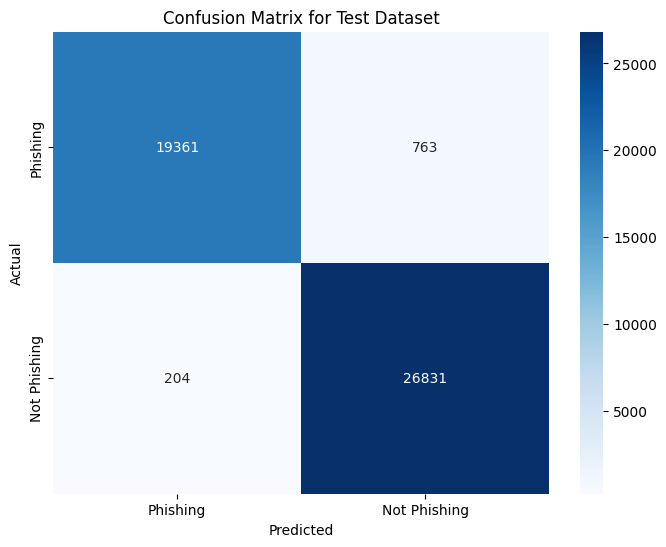

Test dataset accuracy: 99.25%


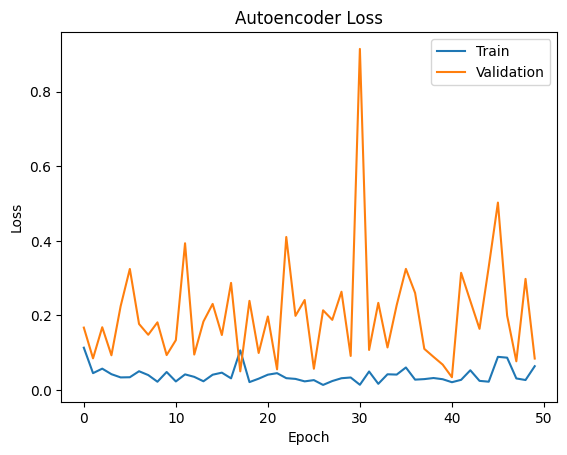

In [ ]:
print("Classification Report:")
print(classification_report(y_test_lra_web, y_pred_lra_web))

lra_cm_test_web = confusion_matrix(y_test_lra_web, y_pred_lra_web)

plt.figure(figsize=(8, 6))
sns.heatmap(lra_cm_test_web, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

plt.plot(history_web.history['loss'])
plt.plot(history_web.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Building with URL Only (CNN, LSTM)

In [ ]:
# Load the dataset with only the 'URL' and 'label' columns
df_url = data[['URL', 'label']]

print(df_url.head())

                                  URL  label
0    https://www.southbankmosaics.com      1
1            https://www.uni-mainz.de      1
2      https://www.voicefmradio.co.uk      1
3         https://www.sfnmjournal.com      1
4  https://www.rewildingargentina.org      1


In [ ]:
# Check the number of rows in the reduced dataset
total_rows = df_url.shape[0]
print(f"Total number of rows: {total_rows}")

# Check for empty (NaN) values in the 'URL' column
empty_values_count = df_url['URL'].isna().sum()
print(f"Number of empty (NaN) values: {empty_values_count}")

# Check for duplicated values in the 'URL' column
duplicate_values_count = df_url['URL'].duplicated().sum()
print(f"Number of duplicated values: {duplicate_values_count}")

Total number of rows: 235795
Number of empty (NaN) values: 0
Number of duplicated values: 425


In [ ]:
# Drop the duplicated URLs
df_url = df_url.drop_duplicates()

# Check the number of rows after dropping duplicates
print(f"Total number of rows after removing duplicates: {df_url.shape[0]}")

Total number of rows after removing duplicates: 235370


#### Preprocessing URL

In [ ]:
# Define parameters for tokenization and padding
max_vocab_size = 10000  # Max number of unique tokens (characters)
max_sequence_length = 100  # Max length of each URL sequence
embedding_dim = 128

# Separate URLs and labels
urls = df_url['URL']
labels = df_url['label']

# Initialize the tokenizer for character-level tokenization
tokenizer = Tokenizer(num_words=max_vocab_size, char_level=True)
tokenizer.fit_on_texts(urls)

# Check the vocabulary
print(len(tokenizer.word_index))

# Convert URLs to sequences of integers
url_sequences = tokenizer.texts_to_sequences(urls)

# Check the length of each URL sequence and Calculage some statistics
url_lengths = [len(url) for url in url_sequences]
print("Max URL length:", max(url_lengths))
print("Average URL length:", np.mean(url_lengths))
print("Median URL length:", np.median(url_lengths))
print("Percentage of URLs within 100 characters:", np.sum(np.array(url_lengths) <= 100) / len(url_lengths) * 100)

# Pad sequences to ensure uniform length
url_sequences_padded = pad_sequences(url_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

70
Max URL length: 6097
Average URL length: 35.33992012575944
Median URL length: 28.0
Percentage of URLs within 100 characters: 97.93176700514084


In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(url_sequences_padded, labels, test_size=0.2, random_state=42)

#### CNN Model

In [ ]:
# Define model architecture
cnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
cnn_model.build(input_shape=(None, max_sequence_length))

# Print model summary
cnn_model.summary()

c:\Users\Glenn Sim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,977 (964.75 KB)

 Trainable params: 246,977 (964.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9741 - auc: 0.9906 - loss: 0.2382 - precision: 0.9633 - recall: 0.9961 - val_accuracy: 0.9945 - val_auc: 0.9977 - val_loss: 0.0631 - val_precision: 0.9905 - val_recall: 1.0000
Epoch 2/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9955 - auc: 0.9976 - loss: 0.0604 - precision: 0.9929 - recall: 0.9993 - val_accuracy: 0.9964 - val_auc: 0.9980 - val_loss: 0.0486 - val_precision: 0.9937 - val_recall: 1.0000
Epoch 3/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9960 - auc: 0.9979 - loss: 0.0484 - precision: 0.9938 - recall: 0.9992 - val_accuracy: 0.9973 - val_auc: 0.9981 - val_loss: 0.0403 - val_precision: 0.9959 - val_recall: 0.9995
Epoch 4/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9959 - auc: 0.9977 - loss: 0.0492 - precision: 0.9937 - recall: 0.9991 - val_accuracy: 0.9973 - val_auc: 0.9981 - val_loss: 0.0474 - val_precision: 0.9958 - val_recall: 0.9995
Epoch 5/10
4708/4708

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9977 - auc: 0.9986 - loss: 0.0286 - precision: 0.9960 - recall: 1.0000
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Loss: 0.02791043370962143
Test Accuracy: 0.9979181885719299
Test Precision: 0.9964045882225037
Test Recall: 1.0
Test AUC: 0.9986932873725891
Test F1 Score: 0.9981990591002646


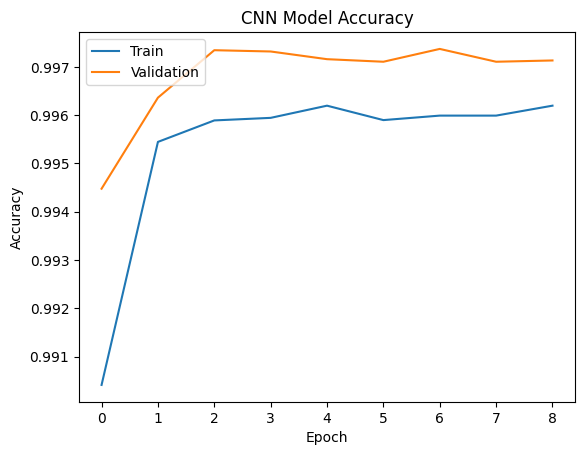

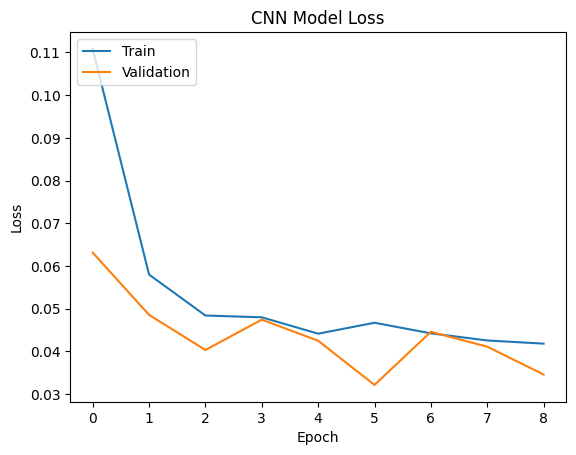

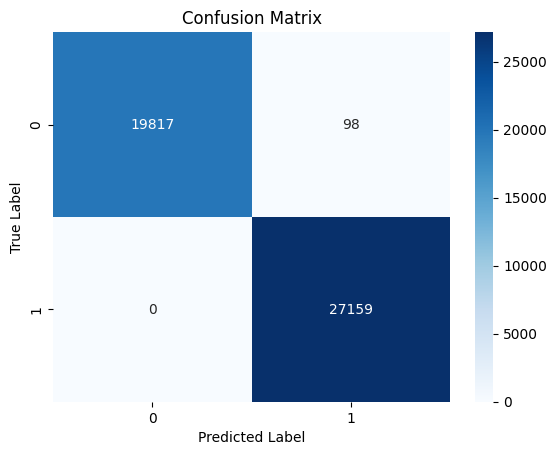

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = cnn_model.evaluate(X_test, y_test, verbose=1)

y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)

# Print each metric
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {f1}")

# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate confusion matrix
cnn_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Bidirectional LSTM

In [ ]:
# Define model architecture
biLSTM_model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
biLSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
biLSTM_model.build(input_shape=(None, max_sequence_length))

# Print model summary
biLSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,225 (454.00 KB)

 Trainable params: 116,225 (454.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
biLSTM_history = biLSTM_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.9710 - auc_1: 0.9873 - loss: 0.0749 - precision_1: 0.9615 - recall_1: 0.9918 - val_accuracy: 0.9971 - val_auc_1: 0.9976 - val_loss: 0.0159 - val_precision_1: 0.9949 - val_recall_1: 1.0000
Epoch 2/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - accuracy: 0.9969 - auc_1: 0.9974 - loss: 0.0202 - precision_1: 0.9952 - recall_1: 0.9994 - val_accuracy: 0.9976 - val_auc_1: 0.9976 - val_loss: 0.0153 - val_precision_1: 0.9959 - val_recall_1: 1.0000
Epoch 3/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.9975 - auc_1: 0.9976 - loss: 0.0170 - precision_1: 0.9959 - recall_1: 0.9998 - val_accuracy: 0.9969 - val_auc_1: 0.9978 - val_loss: 0.0181 - val_precision_1: 0.9965 - val_recall_1: 0.9981
Epoch 4/10
4708/4708 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - accuracy: 0.9976 - auc_1: 0.9978 - loss: 0.0162 - precision_1: 0.9962 - recall_1: 0.9997 - val_accuracy: 0.9978 - val_auc_1: 0.9978 - val_loss: 0.0141 - val_precision_1

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9984 - auc_1: 0.9987 - loss: 0.0100 - precision_1: 0.9973 - recall_1: 0.9999
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Test Loss: 0.009761616587638855
Test Accuracy: 0.9984492659568787
Test Precision: 0.9975020289421082
Test Recall: 0.9998158812522888
Test AUC: 0.9987649321556091
Test F1 Score: 0.9986576193891249


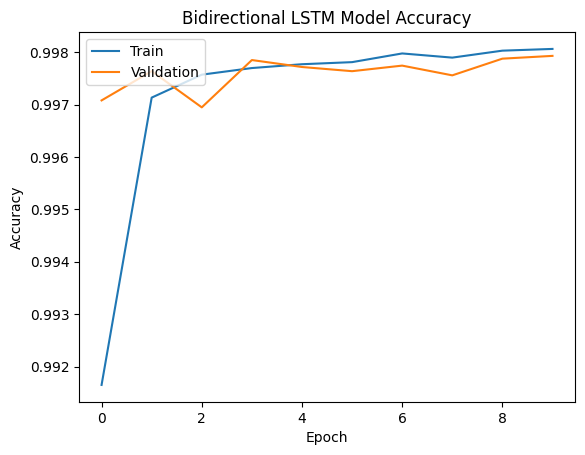

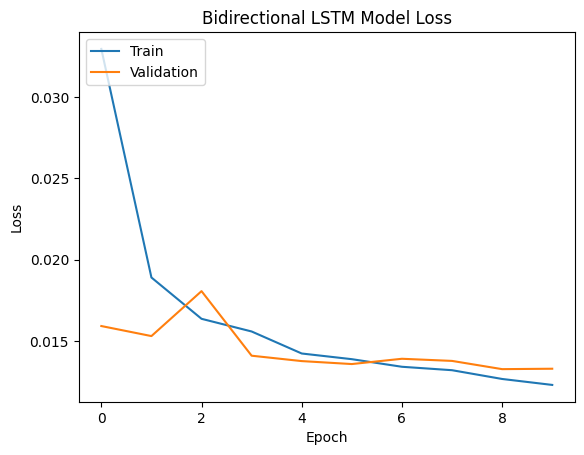

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


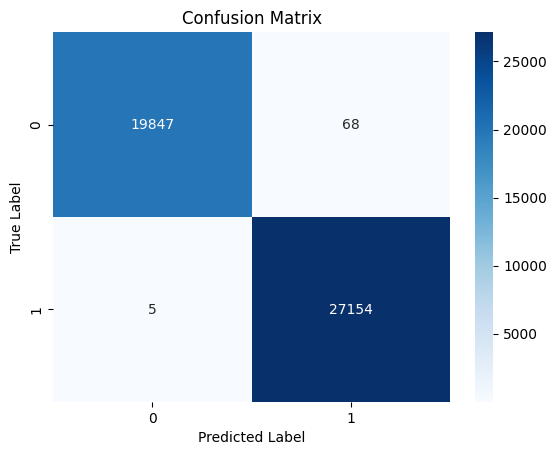

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = biLSTM_model.evaluate(X_test, y_test, verbose=1)

y_pred = (biLSTM_model.predict(X_test) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)

# Print each metric
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {f1}")

# Plot training & validation accuracy values
plt.plot(biLSTM_history.history['accuracy'])
plt.plot(biLSTM_history.history['val_accuracy'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(biLSTM_history.history['loss'])
plt.plot(biLSTM_history.history['val_loss'])
plt.title('Bidirectional LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate confusion matrix
y_pred = (biLSTM_model.predict(X_test) > 0.5).astype("int32")
biLSTM_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(biLSTM_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## CNN-BidirectionalLSTM Model

In [ ]:
# Define model architecture
combined_model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim),

    # CNN layers for feature extraction
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    # Bidirectional LSTM layer for sequential feature learning
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))),
    Dropout(0.5),

    # Dense layers for classification
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
combined_model.build(input_shape=(None, max_sequence_length))

# Print model summary
combined_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,569 (646.75 KB)

 Trainable params: 165,569 (646.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
combined_history = combined_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
2354/2354 ━━━━━━━━━━━━━━━━━━━━ 198s 80ms/step - accuracy: 0.9480 - auc_4: 0.9788 - loss: 0.1775 - precision_4: 0.9294 - recall_4: 0.9949 - val_accuracy: 0.9974 - val_auc_4: 0.9981 - val_loss: 0.0182 - val_precision_4: 0.9961 - val_recall_4: 0.9994
Epoch 2/10
2354/2354 ━━━━━━━━━━━━━━━━━━━━ 188s 80ms/step - accuracy: 0.9962 - auc_4: 0.9977 - loss: 0.0246 - precision_4: 0.9946 - recall_4: 0.9988 - val_accuracy: 0.9977 - val_auc_4: 0.9981 - val_loss: 0.0162 - val_precision_4: 0.9960 - val_recall_4: 1.0000
Epoch 3/10
2354/2354 ━━━━━━━━━━━━━━━━━━━━ 192s 82ms/step - accuracy: 0.9973 - auc_4: 0.9980 - loss: 0.0189 - precision_4: 0.9956 - recall_4: 0.9996 - val_accuracy: 0.9975 - val_auc_4: 0.9980 - val_loss: 0.0167 - val_precision_4: 0.9964 - val_recall_4: 0.9992
Epoch 4/10
2354/2354 ━━━━━━━━━━━━━━━━━━━━ 189s 80ms/step - accuracy: 0.9976 - auc_4: 0.9983 - loss: 0.0166 - precision_4: 0.9963 - recall_4: 0.9996 - val_accuracy: 0.9977 - val_auc_4: 0.9978 - val_loss: 0.0174 - val_precisi

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9983 - auc_4: 0.9985 - loss: 0.0108 - precision_4: 0.9975 - recall_4: 0.9995
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Test Loss: 0.010145559906959534
Test Accuracy: 0.9985129833221436
Test Precision: 0.9976850748062134
Test Recall: 0.9997422695159912
Test AUC: 0.9985789060592651
Test F1 Score: 0.998712620002207


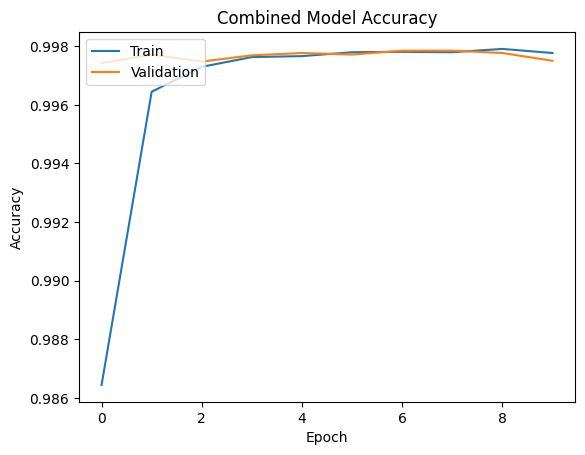

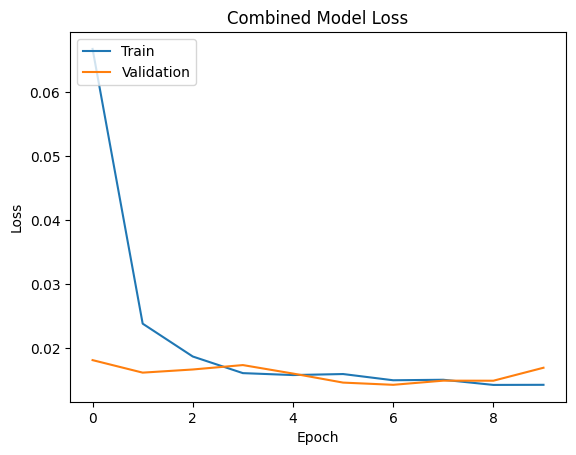

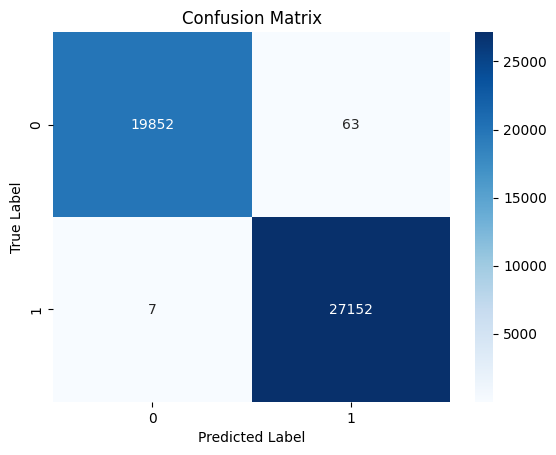

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = combined_model.evaluate(X_test, y_test, verbose=1)

y_pred = (combined_model.predict(X_test) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)

# Print each metric
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {f1}")

# Plot training & validation accuracy values
plt.plot(combined_history.history['accuracy'])
plt.plot(combined_history.history['val_accuracy'])
plt.title('Combined Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(combined_history.history['loss'])
plt.plot(combined_history.history['val_loss'])
plt.title('Combined Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate confusion matrix
combined_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Model Building with Important Features Only

#### Logistic Regression

From previous models, we can see that IsHTTPS, URLLength, DomainLength are the top three features.

In [ ]:
data_reduced.columns

Index(['URLLength', 'DomainLength', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'TLDLength',
       'NoOfSubDomain', 'NoOfObfuscatedChar', 'LetterRatioInURL',
       'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle',
       'DomainTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive',
       'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
       'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label'],
      dtype='object')

In [ ]:
columns_to_keep_lr_imp = ['IsHTTPS', 'URLLength', 'DomainLength', 'label']

data_reduced_lr_imp = data_reduced[columns_to_keep_lr_imp]

data_reduced_lr_imp.head()

,IsHTTPS,URLLength,DomainLength,label
0,1,31,24,1
1,1,23,16,1
2,1,29,22,1
3,1,26,19,1
4,1,33,26,1


In [ ]:
print("\nNumber of remaining features:")
print(data_reduced_lr_imp.shape[1])


Number of remaining features:
4


In [ ]:
# Identify the features (X) and target (y)
# (1 for legitimate, 0 for phishing)
X_lr_imp = data_reduced_lr_imp.drop('label', axis=1)
y_lr_imp = data_reduced_lr_imp['label']

# Train-test split
X_train_lr_imp, X_test_lr_imp, y_train_lr_imp, y_test_lr_imp = train_test_split(X_lr_imp, y_lr_imp, test_size=0.2, random_state=42)

In [ ]:
model_lr_imp = LogisticRegression(max_iter=10000)
model_lr_imp.fit(X_train_lr_imp, y_train_lr_imp)
y_pred_lr_imp = model_lr_imp.predict(X_test_lr_imp)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       0.99      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



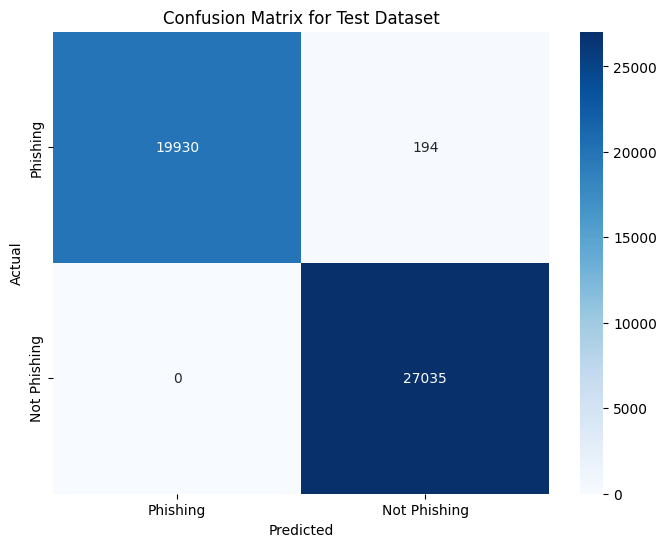

Test dataset accuracy: 100.00%

Top 10 Most Important Features:
        feature  importance
0       IsHTTPS   22.443526
1     URLLength    9.821380
2  DomainLength    9.632138


In [ ]:
#Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test_lr_imp, y_pred_lr_imp))

lr_cm_test_imp = confusion_matrix(y_test_lr_imp, y_pred_lr_imp)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm_test_imp, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

feature_importance_imp = pd.DataFrame({
    'feature': X_lr_imp.columns,
    'importance': abs(model_lr_imp.coef_[0])
})
print("\nTop 10 Most Important Features:")
print(feature_importance_imp.sort_values('importance', ascending=False).head(10))

### Decision Tree

In [ ]:
columns_to_keep_dt_imp = ['URLSimilarityIndex', 'LineOfCode', 'IsHTTPS', 'label']

data_reduced_dt_imp = data_reduced[columns_to_keep_dt_imp]

data_reduced_dt_imp.head()

,URLSimilarityIndex,LineOfCode,IsHTTPS,label
0,100.0,558,1,1
1,100.0,618,1,1
2,100.0,467,1,1
3,100.0,6356,1,1
4,100.0,6089,1,1


In [ ]:
print("\nNumber of remaining features:")
print(data_reduced_dt_imp.shape[1])


Number of remaining features:
4


In [ ]:
X_dt_imp = data_reduced_dt_imp.drop('label', axis=1)
y_dt_imp = data_reduced_dt_imp['label']

# Train-test split
X_train_dt_imp, X_test_dt_imp, y_train_dt_imp, y_test_dt_imp = train_test_split(X_dt_imp, y_dt_imp, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Decision Tree Classifier
dt_imp = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search with cross-validation (5-fold)
grid_search_imp = GridSearchCV(estimator=dt_imp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_imp.fit(X_train_dt_imp, y_train_dt_imp)

# Get the best hyperparameters and refit the model with the best estimator
best_dt_imp = grid_search_imp.best_estimator_
print(f"Best Hyperparameters: {grid_search_imp.best_params_}")

# Train the model using the best hyperparameters on the resampled training data
best_dt_imp.fit(X_train_dt_imp, y_train_dt_imp)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Make predictions
y_pred_dt_imp = best_dt_imp.predict(X_test_dt_imp)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_dt_imp, y_pred_dt_imp))

Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



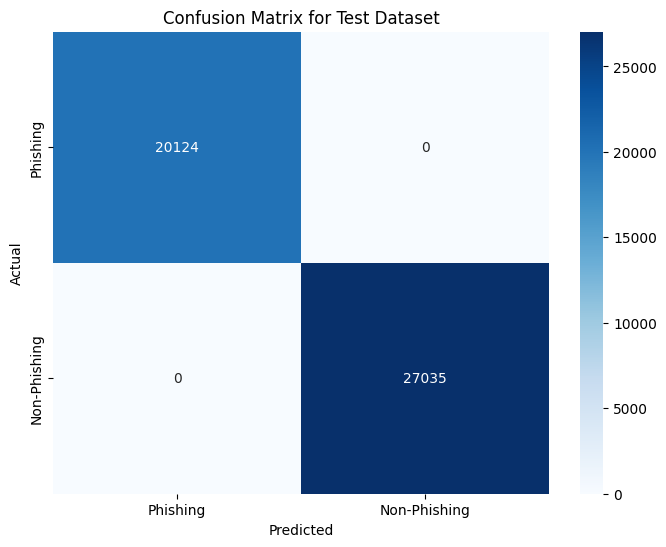

Test dataset accuracy: 100.00%
              Feature  Importance
0  URLSimilarityIndex    0.986438
1          LineOfCode    0.013150
2             IsHTTPS    0.000411


In [ ]:
dt_cm_test_imp = confusion_matrix(y_test_dt_imp, y_pred_dt_imp)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm_test_imp, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

feature_importances_dt_imp = best_dt_imp.feature_importances_

# Display feature importance
importance_dt_imp = pd.DataFrame({
    'Feature': X_dt_imp.columns,
    'Importance': feature_importances_dt_imp
})

# Sort the DataFrame by importance score in descending order
importance_dt_imp = importance_dt_imp.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(importance_dt_imp)